# 1. Prepare the environment

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-abb694d2-066f-97d5-a00b-b58a536feeef)


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import cv2 as cv

# 2. Prepair Image list

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [8]:
import os
import pandas as pd
from sklearn.utils import shuffle

images = []
dirp = "/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/"
for f in os.listdir(dirp):
    if "jpg" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
          
df_origin = pd.DataFrame(images, columns = ["EggPlantType", "path"])


df = shuffle(df_origin, random_state = 0)
df = df.reset_index(drop=True)

EggPlant_names = sorted(df.EggPlantType.unique())
mapper_EggPlant_names = dict(zip(EggPlant_names, [t for t in range(len(EggPlant_names))]))
df["label"] = df["EggPlantType"].map(mapper_EggPlant_names)
print(mapper_EggPlant_names)

df.head()

{'Long_Eggplant': 0, 'Pea_Eggplant': 1, 'Thai_Eggplant': 2, 'Tomato': 3}


,EggPlantType,path,label
0,Long_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,0
1,Long_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,0
2,Thai_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,2
3,Long_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,0
4,Pea_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,1
...,...,...,...
623,Long_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,0
624,Tomato,/content/drive/MyDrive/Colab Notebooks/DADS720...,3
625,Pea_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,1
626,Long_Eggplant,/content/drive/MyDrive/Colab Notebooks/DADS720...,0


In [36]:
filelist = df.path

instances = []
img_w, img_h = 224,224
for file_name in filelist:
  print(file_name)
  img = tf.keras.preprocessing.image.load_img(file_name, target_size = (img_w, img_h))
  instances.append(img)

/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Long_Eggplant/Long eggplant (130).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Long_Eggplant/Long eggplant (95).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Thai_Eggplant/ThaiEggplant (126).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Long_Eggplant/Long eggplant (78).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Pea_Eggplant/pea_eggplant (134).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Tomato/Tomato (33).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Thai_Eggplant/ThaiEggplant (35).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Thai_Eggplant/ThaiEggplant (141).jpg
/content/drive/MyDrive/Colab Notebooks/DADS7202_DeepLearning/01_DataSet_image/Long_Eggplant/Lon

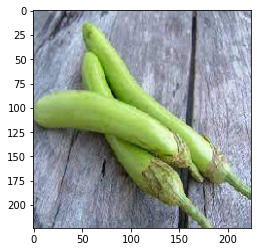

In [11]:
x = tf.keras.preprocessing.image.img_to_array(instances[0])
plt.imshow(x.astype(np.uint8))

In [12]:
#COnvert PIL image to Numpy Array
img_list = []

for img in instances:
    x = tf.keras.preprocessing.image.img_to_array(img)
    img_list.append(x.astype(np.uint8))

In [13]:
img_array = np.array(img_list)
img_array.shape

(628, 224, 224, 3)

In [30]:
# get Y or label
label_data = df.label
label_data = np.expand_dims(label_data, axis = 1)
ans_list = list(set(df.EggPlantType))

In [31]:
label_data.shape

(628, 1)

In [32]:
x_train, x_test, y_train, y_test = train_test_split(img_array, label_data, test_size=0.30, random_state=42)

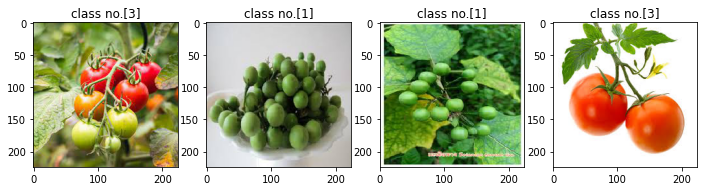

In [39]:
#visualize
plt.figure(figsize = (15,5))
for i in range(4):
    plt.subplot(150+1+i).set_title(f"class no.{y_train[i]}")
    plt.imshow(x_train[i])
plt.show()

In [40]:
# Plot y_train and count value
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 109, 1: 104, 2: 104, 3: 122}

# 3. Load the pretrained model



In [42]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
# By default, VGG-16 is designed for an input image of dimension 224x224x3

np.random.seed(160)
tf.random.set_seed(61)

vgg = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=True)
vgg.trainable = False # Not trainable weights

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#4. Train Model

In [43]:
#Preprocessing
x_train_vgg = tf.keras.applications.vgg16.preprocess_input(x_train)
x_test_vgg = tf.keras.applications.vgg16.preprocess_input(x_test)

In [109]:
#Add new classification head
x = vgg.output

#add custom layer to end of existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(5)(x)
new_outputs = tf.keras.activations.softmax(new_outputs)

#Constrauct the main model
model = tf.keras.models.Model(inputs = vgg.inputs, outputs = new_outputs)
model.compile(loss = "sparse_categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"])
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [110]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="best_weights.hdf5",  monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]
#history = model.fit(x_train_vgg, y_train,
#          validation_data=(x_test_vgg,y_test),
#          callbacks=[callbacks_list],
#          batch_size=100,
#          verbose=2, epochs=100)

history = model.fit(x_train_vgg, y_train, callbacks=[callbacks_list], batch_size=100, verbose=2, epochs=100, validation_split = 0.2)

Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.64773, saving model to best_weights.hdf5
4/4 - 3s - loss: 1.5966 - accuracy: 0.4274 - val_loss: 1.5711 - val_accuracy: 0.6477 - 3s/epoch - 652ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.64773 to 0.73864, saving model to best_weights.hdf5
4/4 - 1s - loss: 1.5371 - accuracy: 0.6097 - val_loss: 1.4913 - val_accuracy: 0.7386 - 1s/epoch - 313ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.73864
4/4 - 0s - loss: 1.4413 - accuracy: 0.6154 - val_loss: 1.3459 - val_accuracy: 0.7273 - 355ms/epoch - 89ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.73864 to 0.75000, saving model to best_weights.hdf5
4/4 - 1s - loss: 1.2682 - accuracy: 0.6325 - val_loss: 1.1191 - val_accuracy: 0.7500 - 1s/epoch - 329ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.75000 to 0.78409, saving model to best_weights.hdf5
4/4 - 5s - loss: 1.0223 - accuracy: 0.6980 - val_loss: 0.9094 - val_accuracy: 0.7841 - 5s

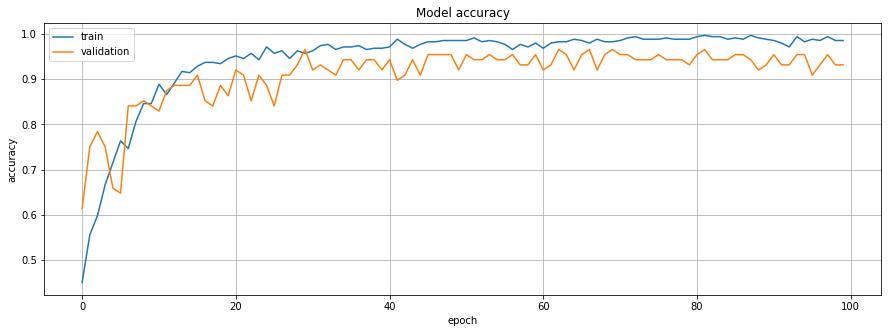

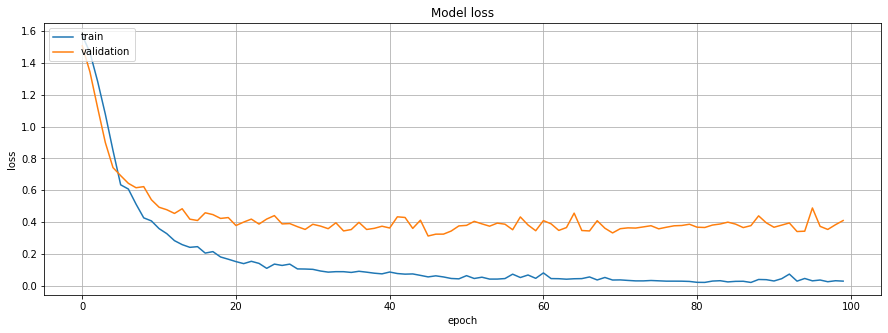

In [48]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid()
plt.show()

1/1 [==============================] - 0s 18ms/step


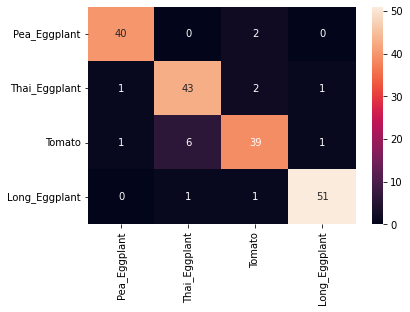

In [105]:
#Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_name = ans_list

y_pred = []
for i in range(len(x_test_vgg)):
  x_input = x_test_vgg[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, xticklabels = class_name, yticklabels = class_name)

#5. Evaluate model on test set

In [49]:
model.load_weights('best_weights.hdf5')

In [106]:
#Evaluation
results = model.evaluate(x_test_vgg, y_test, batch_size = 100)
print(f"{model.metrics_names}: {results}")

2/2 [==============================] - 0s 73ms/step - loss: 0.3366 - accuracy: 0.9153
['loss', 'accuracy']: [0.3365502655506134, 0.9153439402580261]


1/1 [==============================] - 0s 24ms/step


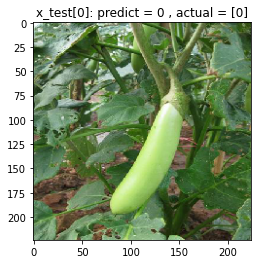

1/1 [==============================] - 0s 19ms/step


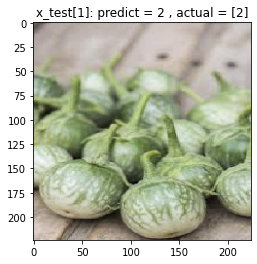

1/1 [==============================] - 0s 19ms/step


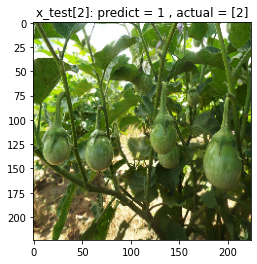

1/1 [==============================] - 0s 19ms/step


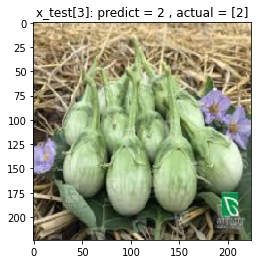

1/1 [==============================] - 0s 19ms/step


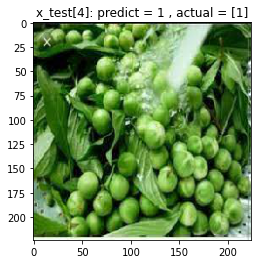

In [108]:
class_name = ans_list
#Test for first 5 images
for i in range(5):
  y_pred = model.predict(x_test_vgg[i].reshape(1, 224, 224, 3))

  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} , actual = {y_test[i]}')
  plt.show()

  # {'Long_Eggplant': 0, 'Pea_Eggplant': 1, 'Thai_Eggplant': 2, 'Tomato': 3}

# 6. Adapt the base model

In [52]:
model.layers[-2].activation

<function keras.activations.linear(x)>

In [54]:
def alter_model_for_GradCAM( model, last_conv_layer_name ):
  # 1. Get the output from the layer
  last_conv_output = model.get_layer( last_conv_layer_name ).output
  out_linear = model.layers[-2].output
  out_softmax = model.layers[-1].output
  # 3. Create the new model and assign the weight for the 'prediction_linear' layer
  new_model = tf.keras.Model( inputs=model.inputs, outputs=[out_softmax, out_linear, last_conv_output] )

  return new_model

In [55]:
new_model = alter_model_for_GradCAM( model, 'block5_pool')
new_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [56]:
new_model.output

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'tf.nn.softmax_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_15')>,
 <KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>]

# 7. GradCAM

--2022-10-16 14:51:18--  https://upload.wikimedia.org/wikipedia/commons/6/6c/Tomato-global.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480231 (469K) [image/png]
Saving to: ‘Tomato-global.png’

Tomato-global.png   100%[===================>] 468.98K  --.-KB/s    in 0.1s    

2022-10-16 14:51:18 (3.96 MB/s) - ‘Tomato-global.png’ saved [480231/480231]



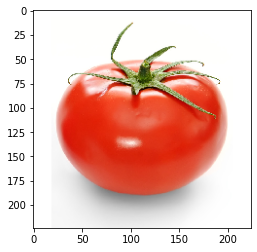

In [95]:
# Load a test image from Internet
#Thai-EggPlant: https://wingmarts.com/media/user_299/23627/UBM-V027.jpg 
img_url =  "https://upload.wikimedia.org/wikipedia/commons/6/6c/Tomato-global.png"
!wget "$img_url"

# Load an image as PIL.Image.IMage
img_path = img_url.split("/")[-1]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_w, img_h))

# Convert PIL Image to Numpy ndarray
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype(np.uint8)

# Display the NumPy image
plt.imshow(img)
plt.show()

In [96]:
# Preprocess the input image
img_preprocess = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(img, axis=0))

In [97]:
result = model.predict(img_preprocess)
print(result)

1/1 [==============================] - 0s 24ms/step
[[6.3887332e-04 3.7108981e-05 4.2757232e-04 9.9888676e-01 9.6973008e-06]]


In [98]:
def my_CNN_GradCAM( model, in_img, class_index ):
  # Convert from numpy to tensor
  in_img = tf.cast( in_img, tf.float32 )

  # Compute the gradient of y_c with respect to A_i
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_softmax, y_linear, last_conv_activation = model( in_img )
    one_class_score = y_linear[..., class_index ]
    gradient = tape.gradient( one_class_score, last_conv_activation )

    # Compute a vector of alphas (one alpha value is one weight for one 2D feature map) by averaging each 2Dgradient
    gradient = gradient.numpy().squeeze(axis=0)
    alpha = np.mean( gradient, axis=(0,1))

    # Compute the weighted-sum heatmap
    last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)
    heatmap = np.dot(last_conv_activation, alpha)

    # Don't hightlight any pixels with negative gradients (= apply ReLU)
    heatmap = np.maximum(0, heatmap)

    # Return an unnormalized heatmap
    return heatmap

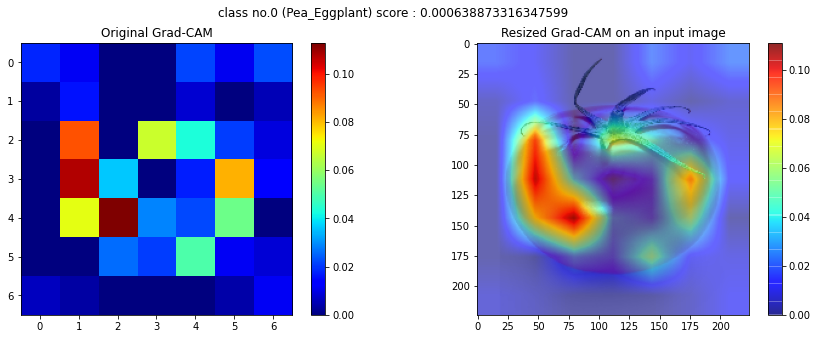

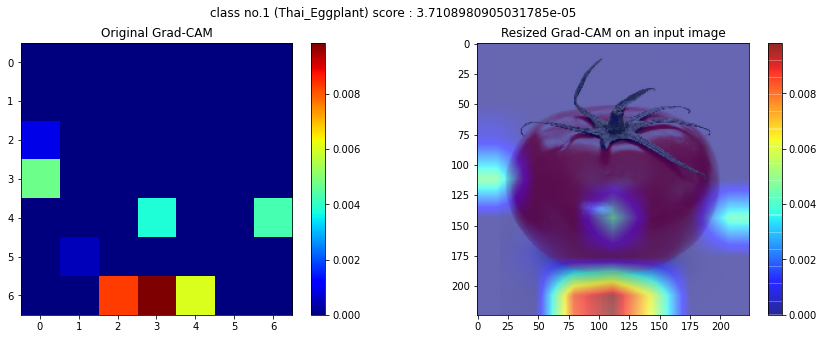

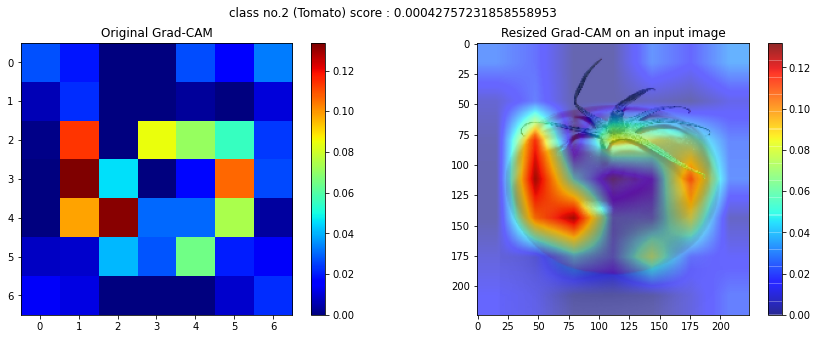

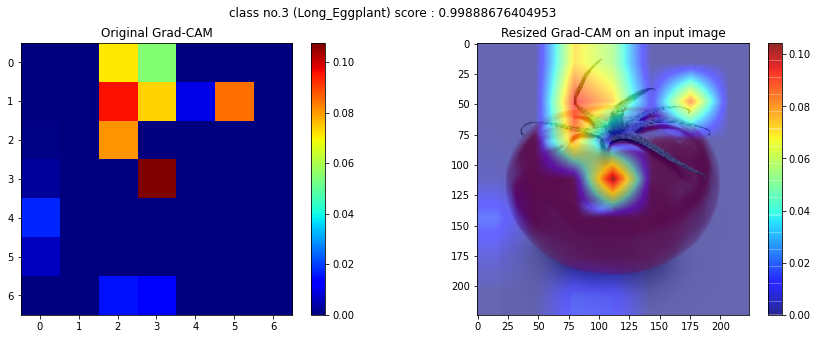

In [99]:
#@title Default title text
# Get predictions with highest scores
top = 4
#_, top_results = my_imagenet_decode_predictions( out_softmax, top=top )

# Extract 0-based class indices
#top_index = [ tp[0] for tp in top_results[0] ]
top_index = [0,1,2,3]
# Visualize Grad-CAM for each class whose index is in 'top_index'
#for i,c in enumerate(top_index):
#class_desc = f"{imagenet_dict[c][-1]}, Top {i+1} score of {out_softmax[...,c].squeeze()}"
for c in range(top):
  heatmap = my_CNN_GradCAM( new_model,       # the CNN model
                            img_preprocess,   # input of the model
                            c                 # the 0-based index of the output class to compute and visualize Grad-CAM
                            )
  # Create the main figure
  fig = plt.figure(figsize=(15,5))
  class_desc = ans_list[c]
  fig.suptitle(f"class no.{c} ({class_desc}) score : {result.item(c)}")


  # Visualize the original heatmap
  ax = fig.add_subplot(1,2,1)
  ax.set_title("Original Grad-CAM")
  im = ax.imshow(heatmap, cmap='jet')
  plt.colorbar(im,ax=ax)

  # Visualize the heatmap overlaid on an input image
  ax = fig.add_subplot(1,2,2)
  ax.set_title("Resized Grad-CAM on an input image")
  ax.imshow(img)
  alpha = 0.6
  im = ax.imshow(cv.resize(heatmap,img.shape[:2]), cmap='jet', alpha=alpha)
  plt.colorbar(im,ax=ax)

  #Show this figure (containing two subplots)
  plt.show()